In [79]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')


df = text_embeddings_metadata_results_preprocessing(df, models=ALL_MODELS)
METRIC = "I(X_1->X_2)/d_2"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:

classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

croissant_classif = classifcation_df.groupby(['model', 'dataset'])['success'].mean().groupby('model').mean().loc[CROISSANT_CHECKPOINT_MODELS]
croissant_classif = croissant_classif.to_frame().rename(columns={'success': 'classification'})
croissant_classif

,classification
model,
croissantllm/base_5k,0.671483
croissantllm/base_50k,0.671767
croissantllm/base_100k,0.644784
croissantllm/base_150k,0.629897
croissantllm/CroissantLLMBase,0.589566
croissantllm/CroissantCool,0.645935


In [81]:

# Make croissant against all informativeness
croissant_info = []
for croissant_model in CROISSANT_CHECKPOINT_MODELS:
    _df = text_embeddings_metadata_results_preprocessing(df, models=(set(ALL_MODELS) - set(CROISSANT_CHECKPOINT_MODELS)) | {croissant_model})
    croissant_info.append({
        'model': croissant_model,
        METRIC : make_table_pivot(METRIC, _df).median(axis=1).loc[croissant_model]
    })

croissant_info = pd.DataFrame(croissant_info)
# apply short names

croissant = croissant_info.merge(croissant_classif, left_on='model', right_index=True)
croissant['model'] = map_short(croissant['model'].tolist())

/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/a

/tmp/ipykernel_190765/4062854185.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)


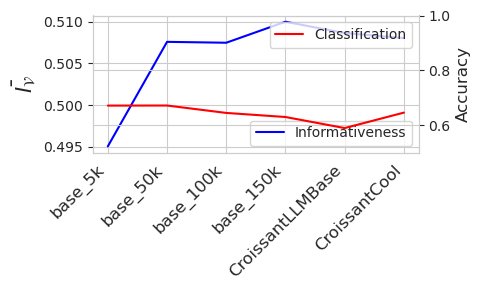

In [93]:

fig, ax = plt.subplots(figsize=(5, 3))

twin_ax = ax.twinx()

sns.lineplot(data=croissant, x='model', y=METRIC, ax=ax, color='blue', label="Informativeness")
# rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)

ax.set_ylabel('$\\bar{I_{\\mathcal{V}}}$', fontsize=15)
ax.set_xlabel('',)

sns.lineplot(data=croissant, x='model', y='classification', ax=twin_ax, color='red', label="Classification")
twin_ax.set_ylabel('Accuracy', fontsize=12)

twin_ax.set_ylim(0.5, 1)
fig.tight_layout()


path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_croissant_training_info_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')
